In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
import matplotlib.lines as mlines

sns.set(font_scale=1, rc={'text.usetex': True})
sns.set_style("whitegrid")


In [919]:
pal = sns.color_palette("husl", 2)
flatui = pal.as_hex()

In [ ]:
alphas = [1.0, 0.9, 0.5 , 0.25, 0.1, 0.01]
gammas = [0.95, 0.98, 0.99, 1.0]
prices = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

df_all = pd.DataFrame()

settings = 360
modes = 2
runs = 5

x_prices = np.zeros((settings, modes))
y_alpha = np.zeros((settings, modes))
y_gamma = np.zeros((settings, modes))
z_rewards = np.zeros((settings, modes))

setting = 0
for alpha in alphas:
    for gamma in gammas:
        for price in prices:
            log_str = 'alpha-{}-gamma-{}-price-{}.csv'.format(alpha, gamma, price)
            log_dir = os.path.join('exps', log_str)
            df = pd.read_csv(log_dir)
                        
            for run in range(runs):
                for mode in range(modes):
                    df_run_setting = df.loc[(df.setting == mode) & (df.run == run)].tail(100).mean()
                    
                    #print(df_run_setting)
                    x_prices[setting][mode] += df_run_setting.price
                    if run == 0:
                        y_alpha[setting][mode] += df.loc[(df.setting == mode) & (df.run == run)].tail(1).alpha
                        y_gamma[setting][mode] += df.loc[(df.setting == mode) & (df.run == run)].tail(1).gamma
                        z_rewards[setting][mode] += df.loc[(df.setting == mode) & (df.run == run)].tail(1).reward
            
            
            x_prices[setting] = x_prices[setting] / runs
            setting += 1
            
            df_all = df_all.append(df, ignore_index=True)
        



In [ ]:
df_test_episodes = (df_all['i_episode'] >= 1900)
df_test_episodes
df_test = df_all[df_test_episodes].groupby(['alpha', 'gamma', 'price', 'setting']).mean().reset_index()


df_test.loc[(df_test['setting'] == 0.0),'setting'] = "market"
df_test.loc[(df_test['setting'] == 1.0),'setting'] = "no-market"


g = sns.FacetGrid(df_test, row="alpha", col="gamma", hue="setting", margin_titles=True)
g.map(sns.scatterplot, "price", "reward") #, fit_reg=False, x_jitter=.1)
g.add_legend();
plt.savefig('coin-game.pdf')

In [ ]:
log_str = 'rolling-mean-alpha-0.5-gamma-0.95-price-0.8.csv'
log_dir = os.path.join('exps', log_str)
df = pd.read_csv(log_dir)

In [ ]:
df_rolling = pd.DataFrame()
for setting in ['no-market', 'market']:
    for run in range(20):
        df_s_r = df[(df['setting'] == setting) & (df['run'] == run)]
        df_s_r['reward_rolling'] = df_s_r['reward'].rolling(20).mean()
        df_rolling = df_rolling.append(df_s_r, ignore_index=True)

In [ ]:
sns.lineplot(x="i_episode", y="reward_rolling", hue='setting', data=df_rolling)
plt.savefig('plots/market-games-rolling-mean-alpha-0.5-gamma-0.95-price-0.8.pdf')

In [ ]:
df_all = pd.DataFrame()
nb_comps = 25
modes = ['market', 'no-market']

comps = np.linspace(0, 3, nb_comps)

setting = 0
for comp in comps:
    log_str = '3-coord-comp-{}.csv'.format(comp)
    log_dir = os.path.join('exps', log_str)
    df = pd.read_csv(log_dir)
    df_all = df_all.append(df, ignore_index=True)

df_agent_sum = ((df_all['agent'] == 'agent-0') or (df_all['agent'] == 'agent-1'))
df_test_episodes = (df_all['i_episode'] >= 3500)

df_test = df_all[df_agent_sum]
df_test = df_test[df_test_episodes]


In [531]:
flatui = ["#34495e" , "#36ada4"] #, "#b13c6c"] # , "#34495e"]
ax = sns.lineplot(x='comp', y='reward', data=df_test, hue="setting", style="setting",
                   palette=flatui, markers=True, linewidth = 2.2)

l = mlines.Line2D([i for i in comps], [max((0.125*3) + ((0.875*3)-i), i) for i in comps],
                  linestyle='--', color='#7f7f7f', label='Pareto frontier')
ax.add_line(l)

#l = mlines.Line2D([1.5, 1.5], [0.0, 5.0],
#                  linestyle='dashdot', color='black')
ax.add_line(l)
#ax.set(ylim=(0.5, 4))
#ax.text(1.5, 2.8 , 'Pareto frontier', fontweight='bold', fontsize=11, ha='center')
#ax.text(2.2, 2.78 , 'Distributional \n issues', fontweight='bold', fontsize=11, ha='center')

ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax.set_xticklabels([r'$\alpha = 0$', '', '', r'$\alpha = (R_1 + R_2) / 2$','','',r'$\alpha = R_2$'])

h,l = ax.get_legend_handles_labels()
plt.legend(h[0:],l[0:-1], ncol=1, loc='upper center', 
       bbox_to_anchor=[0.2, 0.3], 
       #columnspacing=1.3, labelspacing=0.0,
       #handletextpad=0.0, handlelength=1.5,
       fancybox=True, shadow=True)

ax.set(xlabel='Conflict ' + r'($\alpha$)', ylabel='Overall Reward')
#plt.show()   
plt.savefig('market-games.pdf')

NameError: name 'df_test' is not defined

### 2-Player social dilemmas

In [924]:
def plot_2player_sd(df, name):
    ax = sns.lineplot(data=df,
              x='episode',
              y='reward',
              hue='Game Type',
              #hue_order=['Markov Game', 'Sanction Game'],
              palette=flatui
              )

    #h,l = ax.get_legend_handles_labels()
    #plt.legend(h[0:4]+h[5:],l[0:4]+l[5:])
    ax.set(xlabel='Episode', ylabel='Return')
    #plt.show()
    plt.savefig('{}.pdf'.format(name))
    plt.close()
    
    
def get_env_data_sd(env):
    log_str = '{}.csv'.format(env)
    envs = {'PD': 'Prisoner\'s Dilemma', 'SH': 'Stag Hunt', 'CH': 'Chicken'}
    log_dir = os.path.join('exps', log_str)
    df = None
    if os.path.exists(log_dir):
        df = pd.read_csv(log_dir)
        df.loc[df['setting'] == 'Stochastic Market Game', 'setting'] = '{} with Sanctions'.format(envs[env])
        df.loc[df['setting'] == 'Markov Game', 'setting'] = '{} no Sanctions'.format(envs[env])
        df['reward'] = (df.reward-df.reward.min())/(df.reward.max()-df.reward.min())
        df = df.rename(columns={"setting": "Game Type"})
        df['env'] = name
        df = df[df['agent']=='sum']
    return df

In [925]:
envs = ['PD', 'SH', 'CH']
for env in envs:
    df_new = get_env_data_sd(env)
    plot_2player_sd(df_new, env)

In [1]:
df

NameError: name 'df' is not defined

### N-Player Public good game

In [847]:
def plot_sd(df):
    ax = sns.lineplot(data=df,
                  x='episode',
                  y='reward',
                  hue='Penalty',
                  style='Game Type',
                  #hue_order=['Markov Game', 'Sanction Game'],
                  #palette=flatui
                  )

    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0:4]+h[5:],l[0:4]+l[5:])
    ax.set(xlabel='Episode', ylabel='Return')
    #plt.show()
    plt.savefig('{}-return.pdf'.format(df.iloc[0]['name']))
    plt.close()
    
    ax = sns.lineplot(data=df,
                  x='episode',
                  y='action',
                  hue='Penalty',
                  style='Game Type',
                  #hue_order=['Markov Game', 'Sanction Game'],
                  #palette=flatui
                  )

    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0:4]+h[5:],l[0:4]+l[5:])
    ax.set(xlabel='Episode', ylabel='Cooperation')
    #plt.show()
    plt.savefig('{}-cooperation.pdf'.format(df.iloc[0]['name']))

In [848]:
def get_env_data(name, price, nb_agents, alpha):
    if price is None:
        log_str = '{}-nb-agents-{}-alpha-{}.csv'.format(name, nb_agents, alpha)
    else:
        log_str = '{}-price-{}-nb-agents-{}-alpha-{}.csv'.format(name, price, nb_agents, alpha)
    print(log_str)
    log_dir = os.path.join('exps', log_str)
    df = None
    if os.path.exists(log_dir):
        df = pd.read_csv(log_dir)
        df.loc[df['setting'] == 'Stochastic Market Game', 'setting'] = 'Sanction Game'
        df.loc[df['setting'] == 'Markov Game', 'setting'] = 'No Sanctions'
        df = df[df['agent'] == 'sum']
        #df['reward'] = (df.reward-df.reward.min())/(df.reward.max()-df.reward.min())
        df['price'] = df['price'].astype(str)
        df['alpha'] = str(alpha)
        #df['reward'] = df.reward.rolling(10).mean()
        df['env'] = name                                              
        #df = df.groupby(['episode', 'setting', 'agent', 'price', 'env']).mean().reset_index()
        df = df.rename(columns={"price": "Penalty", "setting": "Game Type"})
        df['name'] = '{}-nb-agents'.format(nb_agents)
    return df

In [853]:
nb_agents = 128
if nb_agents == 16:
    prices = [-30, -40] + [None]
if nb_agents == 32:
    prices = [-20, -40, -70] + [None]
if nb_agents == 64:
    prices = [-50, -100, -160] + [None]
if nb_agents == 128:
    prices = [-60, -150, -300] + [None]

alpha = 0.01

settings = ['n_player_prisoners_dilemma' for _ in range(len(prices))] + ['n_player_prisoners_dilemma']

df = pd.DataFrame()
for name, price in zip(settings, prices):
    df_new = get_env_data(name, price, nb_agents, alpha)
    if df_new is not None:
        df = df.append(df_new)


n_player_prisoners_dilemma-price--60-nb-agents-128-alpha-0.01.csv
n_player_prisoners_dilemma-price--150-nb-agents-128-alpha-0.01.csv
n_player_prisoners_dilemma-price--300-nb-agents-128-alpha-0.01.csv
n_player_prisoners_dilemma-nb-agents-128-alpha-0.01.csv


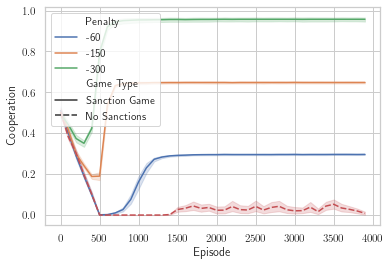

In [854]:
plot_sd(df)

## Shelling Diagramm

In [942]:
def plot_shelling(df):
    ax = sns.boxplot(data= df[df['episode'] < 500],
                     x='setting',
                     y='reward',
                     hue='Agent',
                     hue_order=['Non-Sanctioneer', 'Sanctioneer'],
                     palette=flatui
                     )
    ax.set(xlabel='Sanctioning Agents', ylabel='Return')
    #plt.show()
    #plt.title("Early Training")
    plt.savefig('{}-return-1.pdf'.format(df.iloc[0]['name']))
    plt.close()
    
    ax = sns.boxplot(data= df[df['episode'] > 500],
                 x='setting',
                 y='reward',
                 hue='Agent',
                 hue_order=['Non-Sanctioneer', 'Sanctioneer'],
                 palette=flatui
                 )
    ax.set(xlabel='Sanctioning Agents', ylabel='Return')
    #plt.show()
    #plt.title("Late Training")
    plt.savefig('{}-return-2.pdf'.format(df.iloc[0]['name']))
    plt.close()
        
def get_env_data(name, S, nb_agents, alpha):
    log_str = 'shelling-{}-nb-sanctioneers-{}-nb-agents-{}-alpha-{}.csv'.format(name, S, nb_agents, alpha)
    print(log_str)
    log_dir = os.path.join('exps', log_str)
    df = None
    if os.path.exists(log_dir):
        df = pd.read_csv(log_dir)
        df.loc[df['setting'] == 'Stochastic Market Game', 'setting'] = 'Sanction Game'
        df.loc[df['agent'] == 'sanctioneers', 'agent'] = 'Sanctioneer'
        df.loc[df['agent'] == 'non-sanctioneers', 'agent'] = 'Non-Sanctioneer'
        df['alpha'] = str(alpha)
        df['env'] = name                                              
        df['name'] = '{}-nb-agents'.format(nb_agents)
        df = df.rename(columns={"nb_sanctioneers": "Sanctioneers", "agent": "Agent"})
    return df

In [943]:
nb_agents = 16
nb_sanctioneers = []
for i in range(nb_agents + 1):
    nb_sanctioneers.append(i)
alpha = 0.01
settings = ['n_player_prisoners_dilemma' for _ in range(len(nb_sanctioneers ))]

df = pd.DataFrame()
for name, S in zip(settings, nb_sanctioneers):
    df_new = get_env_data(name, S, nb_agents, alpha)
    if df_new is not None:
        df = df.append(df_new)

shelling-n_player_prisoners_dilemma-nb-sanctioneers-0-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-1-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-2-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-3-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-4-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-5-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-6-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-7-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-8-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-9-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-10-nb-agents-16-alpha-0.01.csv
shelling-n_player_prisoners_dilemma-nb-sanctioneers-11-nb-agents-16-alpha-0.01.csv
shelling-n_pla

In [944]:
plot_shelling(df)

In [941]:
df

,Unnamed: 0,run,episode,setting,Agent,reward,price,action,alpha,env,name
0,0,0,0,0,sanctioneers,0.0,-30,0.5625,0.01,n_player_prisoners_dilemma,16-nb-agents
1,1,0,0,0,non-sanctioneers,81.0,-30,0.5625,0.01,n_player_prisoners_dilemma,16-nb-agents
2,2,0,100,0,sanctioneers,0.0,-30,0.4375,0.01,n_player_prisoners_dilemma,16-nb-agents
3,3,0,100,0,non-sanctioneers,49.0,-30,0.4375,0.01,n_player_prisoners_dilemma,16-nb-agents
4,4,0,200,0,sanctioneers,0.0,-30,0.2500,0.01,n_player_prisoners_dilemma,16-nb-agents
...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,24,3700,16,non-sanctioneers,0.0,-30,0.8750,0.01,n_player_prisoners_dilemma,16-nb-agents
1996,1996,24,3800,16,sanctioneers,196.0,-30,0.8750,0.01,n_player_prisoners_dilemma,16-nb-agents
1997,1997,24,3800,16,non-sanctioneers,0.0,-30,0.8750,0.01,n_player_prisoners_dilemma,16-nb-agents
1998,1998,24,3900,16,sanctioneers,196.0,-30,0.8750,0.01,n_player_prisoners_dilemma,16-nb-agents


In [855]:
from sklearn import preprocessing

def get_env_data_box():
    df_all = pd.DataFrame()
    for name0, name1 in [('CH','Chicken'), ('SH', 'Stag Hunt'), ('PD', 'Priosner\'s Dilemma')]:
        log_str = '{}.csv'.format(name0)
        log_dir = os.path.join('exps', log_str)
        df = pd.read_csv(log_dir)
        df['sd'] = name1

        df = df[df['agent'] == 'agent-sum']
        df['reward'] = (df.reward-df.reward.min())/(df.reward.max()-df.reward.min())

        df = df[df['episode'] > 3900]
        df_all = df_all.append(df, ignore_index=True)
    
    df_all = df_all.groupby(['episode', 'setting', 'agent', 'sd']).mean().reset_index()
    
    return df_all

In [856]:
def plot_sd_box(df):          
    #fig, axs = plt.subplots(ncols=3, nrows=1) #figsize=(16, 6))
    ax = sns.boxplot(data=df,
                     x='sd',
                     y='reward',
                     hue='setting',
                     hue_order=['Stochastic Game', 'Market Game'],
                     order=["Priosner\'s Dilemma", "Chicken", "Stag Hunt"],
                     palette=flatui
                     )
    ax.set_xlabel('')
    # plt.show()   
    plt.savefig('market-games.pdf')

In [857]:
df = get_env_data_box()

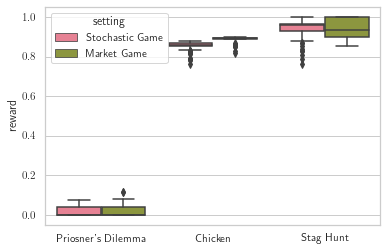

In [858]:
plot_sd_box(df)

### Eval actions

In [844]:
def plot_actions(df):
    
    df = df.rename(columns={"successful_sanction_c": "C", "successful_sanction_d": "D"})
    
    df_1 = df[['episode', 'C', 'D']].melt('episode', var_name='Successful Sanctions',  value_name='Number')
    g = sns.lineplot(x="episode", y="Number", hue='Successful Sanctions', data=df_1)
    g.set(xlabel='Episode', ylabel='Number')
    #plt.show()
    plt.savefig('{}-successful-sanctions.pdf'.format(df.iloc[0]['name']))
    plt.close()
    
    df_2 = df[['episode', 'C-', 'CC', 'CD', 'D-', 'DC', 'DD']].melt('episode', var_name='Action',  value_name='Number')
    g = sns.lineplot(x="episode", y="Number", hue='Action', data=df_2)
    g.set(xlabel='Episode', ylabel='Number')
    plt.savefig('{}-played-actions.pdf'.format(df.iloc[0]['name']))
    #plt.show()
    plt.close()
    
    #df.plot(x='episode', y=['Sanction C', 'Sanction D'])
    
    
def get_env_data_actions(name, price, nb_agents):
    log_str = '{}-price-{}-nb-agents-{}-alpha-0.01.csv'.format(name, price, nb_agents)
    print(log_str)
    log_dir = os.path.join('exps', 'eval-actions', log_str)
    df = None
    if os.path.exists(log_dir):
        df = pd.read_csv(log_dir)
        df.loc[df['setting'] == 'Stochastic Market Game', 'setting'] = 'Sanction Game'
        df['env'] = name                                              
        df['name'] = '{}-nb-agents'.format(nb_agents)
        df = df.rename(columns={"nb_sanctioneers": "Sanctioneers"})
    return df

In [845]:
nb_agents = 64
settings = ['n_player_prisoners_dilemma']
prices = [-160]

df = pd.DataFrame()
for name, price in zip(settings, prices):
    df_new = get_env_data_actions(name, price, nb_agents)
    if df_new is not None:
        df = df.append(df_new)

n_player_prisoners_dilemma-price--160-nb-agents-64-alpha-0.01.csv


In [846]:
plot_actions(df)

In [ ]:
from sklearn import preprocessing

def get_env_data_box_price():
    df_all = pd.DataFrame()
    for name0, name1 in [('PD', 'Priosner\'s Dilemma')]:
        for price in [-1.9, -2.0]:
            log_str = '{}-price-{}.csv'.format(name0, price)
            log_dir = os.path.join('exps', log_str)
            df = pd.read_csv(log_dir)
            df['sd'] = name1
            
            df = df[df['agent'] == 'agent-sum']
            df['reward'] = (df.reward-df.reward.min())/(df.reward.max()-df.reward.min())
            
            df = df[df['episode'] > 3900]
            df_all = df_all.append(df, ignore_index=True)
    
    df_all = df_all.groupby(['episode', 'setting', 'agent', 'price', 'sd']).mean().reset_index()
    
    return df_all

In [ ]:
def plot_sd_box_price(df):          
    #fig, axs = plt.subplots(ncols=3, nrows=1) #figsize=(16, 6))
    ax = sns.boxplot(data=df,
                     x='price',
                     y='reward',
                     hue='setting',
                     hue_order=['Stochastic Game', 'Market Game'],
                     palette=flatui
                     )
    ax.set_xlabel('')
    # plt.show()   
    plt.savefig('market-games.pdf')

In [ ]:
df = get_env_data_box_price()

In [ ]:
plot_sd_box_price(df)